<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_2_Convolution_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/guava-disease-dataset


In [3]:
ds_folder = path+"/GuavaDiseaseDataset/GuavaDiseaseDataset/"

In [4]:
img_size = (224, 224)
img_channels = 3
batch_size = 64
lr = 1e-3

# Datasets and DataLoaders

In [5]:
train_dataset = ImageFolder(root=ds_folder + "train/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.RandomHorizontalFlip(0.5),
                                T.RandomVerticalFlip(0.5),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [6]:
test_dataset = ImageFolder(root=ds_folder + "test/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [7]:
val_dataset = ImageFolder(root=ds_folder + "val/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [8]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Training Functins

In [9]:
def train_step(model, data_loader, criterion, optimizer, scheduler):

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Training")
  total_loss = 0.0
  total_correct = 0.0

  model.train()

  for image, label in progress_bar:
    images, labels = image.cuda(), label.cuda()

    optimizer.zero_grad()

    predictions = model(images)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_classes = torch.sum(predicted_classes == labels)
    loss = criterion(predictions, labels)

    total_correct += correct_classes.item()
    total_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
    optimizer.step()
  scheduler.step(loss.item())

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [10]:
def evaluate(model, data_loader, criterion):

  model.eval()

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Evaluating")
  total_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    for image, label in progress_bar:
      images, labels = image.cuda(), label.cuda()

      predictions = model(images)
      predicted_classes = torch.argmax(predictions, dim=1)
      correct_classes = torch.sum(predicted_classes == labels)
      loss = criterion(predictions, labels)

      total_correct += correct_classes.item()
      total_loss += loss.item()

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [11]:
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs, experiment_name):

  df = pd.DataFrame(np.empty([epochs, 5]),
                    index=np.arange(epochs),
                    columns=["Train_Loss", "Train_Acc", "Val_Loss", "Val_Acc", "lr"])

  highest_acc = 0.00

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    df.iloc[epoch, 0], df.iloc[epoch, 1] = train_step(model=model, data_loader=train_dataloader,
                                            criterion=criterion, optimizer=optimizer,
                                            scheduler=scheduler)

    df.iloc[epoch, 2], df.iloc[epoch, 3] = evaluate(model=model, data_loader=val_dataloader,
                                            criterion=criterion)

    df.iloc[epoch, 4] = optimizer.param_groups[0]["lr"]

    print(f"Training Loss = {df.iloc[epoch, 0]:.7f}, Training Accuracy = {df.iloc[epoch, 1]:.3f}\nTesting Loss = {df.iloc[epoch, 2]:.7f}, Testing Accuracy = {df.iloc[epoch, 3]:.3f}")


    if df.iloc[epoch, 3] > highest_acc:
      torch.save(model.state_dict(), f"{experiment_name}.pth")
      highest_acc = df.iloc[epoch, 3]
      print(f"New best accuracy: {highest_acc:.3f} at epoch {epoch+1}")

    print("*"*50)
    print("")

  return df

# FC Neural Network

In [12]:
class FC_Model(nn.Module):
  def __init__(self, skeleton:list, num_classes):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.Dropout1d(0.5))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], num_classes))
    self.model = nn.Sequential(*layer_list)

  def forward(self, images):
    inputs = images.view(images.shape[0], -1)
    output = self.model(inputs)
    return output

In [13]:
model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 100, 50, 20], num_classes=3).cuda()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [15]:
fc_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="fully_connected")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:12<00:00,  6.02it/s]


Training Loss = 0.0169596, Training Accuracy = 41.141
Testing Loss = 0.1010793, Testing Accuracy = 65.166
New best accuracy: 65.166 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.76it/s]


Training Loss = 0.0164355, Training Accuracy = 44.352
Testing Loss = 0.0988061, Testing Accuracy = 70.993
New best accuracy: 70.993 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.57it/s]


Training Loss = 0.0164035, Training Accuracy = 45.259
Testing Loss = 0.0982131, Testing Accuracy = 69.007
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.61it/s]


Training Loss = 0.0164194, Training Accuracy = 44.428
Testing Loss = 0.0969855, Testing Accuracy = 73.245
New best accuracy: 73.245 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.33it/s]


Training Loss = 0.0160646, Training Accuracy = 46.430
Testing Loss = 0.0966146, Testing Accuracy = 72.053
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.80it/s]


Training Loss = 0.0162099, Training Accuracy = 45.108
Testing Loss = 0.0951377, Testing Accuracy = 71.391
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training Loss = 0.0159568, Training Accuracy = 45.410
Testing Loss = 0.0954771, Testing Accuracy = 69.404
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.17it/s]


Training Loss = 0.0160297, Training Accuracy = 45.637
Testing Loss = 0.0956853, Testing Accuracy = 70.993
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.84it/s]


Training Loss = 0.0158646, Training Accuracy = 45.372
Testing Loss = 0.0947066, Testing Accuracy = 72.053
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.29it/s]


Training Loss = 0.0159127, Training Accuracy = 46.165
Testing Loss = 0.0933639, Testing Accuracy = 75.099
New best accuracy: 75.099 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.80it/s]


Training Loss = 0.0159873, Training Accuracy = 45.750
Testing Loss = 0.0936815, Testing Accuracy = 70.199
**************************************************

Epoch 12


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.91it/s]


Training Loss = 0.0159012, Training Accuracy = 46.430
Testing Loss = 0.0927386, Testing Accuracy = 68.344
**************************************************

Epoch 13


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training Loss = 0.0158080, Training Accuracy = 45.712
Testing Loss = 0.0936714, Testing Accuracy = 67.947
**************************************************

Epoch 14


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training Loss = 0.0157179, Training Accuracy = 46.241
Testing Loss = 0.0910584, Testing Accuracy = 72.450
**************************************************

Epoch 15


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.34it/s]


Training Loss = 0.0156443, Training Accuracy = 46.128
Testing Loss = 0.0900125, Testing Accuracy = 74.702
**************************************************

Epoch 16


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.34it/s]


Training Loss = 0.0157243, Training Accuracy = 45.825
Testing Loss = 0.0872102, Testing Accuracy = 76.026
New best accuracy: 76.026 at epoch 16
**************************************************

Epoch 17


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.23it/s]


Training Loss = 0.0158916, Training Accuracy = 45.825
Testing Loss = 0.0875660, Testing Accuracy = 75.099
**************************************************

Epoch 18


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.89it/s]


Training Loss = 0.0154661, Training Accuracy = 47.072
Testing Loss = 0.0887124, Testing Accuracy = 73.113
**************************************************

Epoch 19


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.84it/s]


Training Loss = 0.0155068, Training Accuracy = 47.412
Testing Loss = 0.0881644, Testing Accuracy = 75.232
**************************************************

Epoch 20


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.91it/s]


Training Loss = 0.0154450, Training Accuracy = 47.185
Testing Loss = 0.0894238, Testing Accuracy = 73.245
**************************************************

Epoch 21


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.96it/s]


Training Loss = 0.0156786, Training Accuracy = 46.014
Testing Loss = 0.0859264, Testing Accuracy = 76.026
**************************************************

Epoch 22


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.12it/s]


Training Loss = 0.0155405, Training Accuracy = 47.299
Testing Loss = 0.0858503, Testing Accuracy = 76.821
New best accuracy: 76.821 at epoch 22
**************************************************

Epoch 23


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Training Loss = 0.0156377, Training Accuracy = 46.657
Testing Loss = 0.0862362, Testing Accuracy = 75.894
**************************************************

Epoch 24


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.42it/s]


Training Loss = 0.0157417, Training Accuracy = 45.259
Testing Loss = 0.0865288, Testing Accuracy = 76.424
**************************************************

Epoch 25


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Training Loss = 0.0156204, Training Accuracy = 45.674
Testing Loss = 0.0875363, Testing Accuracy = 75.497
**************************************************

Epoch 26


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.38it/s]


Training Loss = 0.0156280, Training Accuracy = 46.505
Testing Loss = 0.0888027, Testing Accuracy = 74.570
**************************************************

Epoch 27


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.85it/s]


Training Loss = 0.0154939, Training Accuracy = 47.223
Testing Loss = 0.0901726, Testing Accuracy = 70.728
**************************************************

Epoch 28


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.98it/s]


Training Loss = 0.0157077, Training Accuracy = 45.977
Testing Loss = 0.0862235, Testing Accuracy = 75.629
**************************************************

Epoch 29


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.99it/s]


Training Loss = 0.0155037, Training Accuracy = 47.941
Testing Loss = 0.0870823, Testing Accuracy = 74.702
**************************************************

Epoch 30


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.57it/s]


Training Loss = 0.0155033, Training Accuracy = 46.543
Testing Loss = 0.0895870, Testing Accuracy = 72.583
**************************************************

Epoch 31


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.42it/s]


Training Loss = 0.0154570, Training Accuracy = 46.203
Testing Loss = 0.0873861, Testing Accuracy = 76.291
**************************************************

Epoch 32


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.27it/s]


Training Loss = 0.0153466, Training Accuracy = 47.752
Testing Loss = 0.0883421, Testing Accuracy = 74.702
**************************************************

Epoch 33


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  8.93it/s]


Training Loss = 0.0156723, Training Accuracy = 45.599
Testing Loss = 0.0875944, Testing Accuracy = 73.907
**************************************************

Epoch 34


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.56it/s]


Training Loss = 0.0156187, Training Accuracy = 46.241
Testing Loss = 0.0881567, Testing Accuracy = 73.907
**************************************************

Epoch 35


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.88it/s]


Training Loss = 0.0154472, Training Accuracy = 47.261
Testing Loss = 0.0886133, Testing Accuracy = 74.570
**************************************************

Epoch 36


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Training Loss = 0.0156211, Training Accuracy = 46.505
Testing Loss = 0.0887665, Testing Accuracy = 73.377
**************************************************

Epoch 37


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.89it/s]


Training Loss = 0.0156467, Training Accuracy = 46.354
Testing Loss = 0.0874293, Testing Accuracy = 74.834
**************************************************

Epoch 38


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.04it/s]


Training Loss = 0.0155539, Training Accuracy = 46.808
Testing Loss = 0.0885510, Testing Accuracy = 73.377
**************************************************

Epoch 39


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.43it/s]


Training Loss = 0.0154478, Training Accuracy = 47.299
Testing Loss = 0.0892891, Testing Accuracy = 73.377
**************************************************

Epoch 40


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.20it/s]


Training Loss = 0.0153078, Training Accuracy = 47.601
Testing Loss = 0.0855213, Testing Accuracy = 76.556
**************************************************

Epoch 41


Evaluating: 100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


Training Loss = 0.0155784, Training Accuracy = 46.845
Testing Loss = 0.0881237, Testing Accuracy = 73.775
**************************************************

Epoch 42


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.54it/s]


Training Loss = 0.0156361, Training Accuracy = 46.392
Testing Loss = 0.0887193, Testing Accuracy = 73.642
**************************************************

Epoch 43


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.04it/s]


Training Loss = 0.0156745, Training Accuracy = 46.581
Testing Loss = 0.0887489, Testing Accuracy = 73.510
**************************************************

Epoch 44


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.20it/s]


Training Loss = 0.0155308, Training Accuracy = 46.808
Testing Loss = 0.0887831, Testing Accuracy = 73.113
**************************************************

Epoch 45


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.26it/s]


Training Loss = 0.0153893, Training Accuracy = 47.866
Testing Loss = 0.0868034, Testing Accuracy = 76.026
**************************************************

Epoch 46


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.81it/s]


Training Loss = 0.0155467, Training Accuracy = 47.072
Testing Loss = 0.0869860, Testing Accuracy = 75.497
**************************************************

Epoch 47


Evaluating: 100%|██████████| 76/76 [00:07<00:00, 10.02it/s]


Training Loss = 0.0154314, Training Accuracy = 46.581
Testing Loss = 0.0883533, Testing Accuracy = 73.642
**************************************************

Epoch 48


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training Loss = 0.0156125, Training Accuracy = 46.279
Testing Loss = 0.0861551, Testing Accuracy = 76.424
**************************************************

Epoch 49


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.56it/s]


Training Loss = 0.0155201, Training Accuracy = 47.034
Testing Loss = 0.0873083, Testing Accuracy = 75.629
**************************************************

Epoch 50


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]

Training Loss = 0.0157662, Training Accuracy = 46.430
Testing Loss = 0.0880630, Testing Accuracy = 74.437
**************************************************



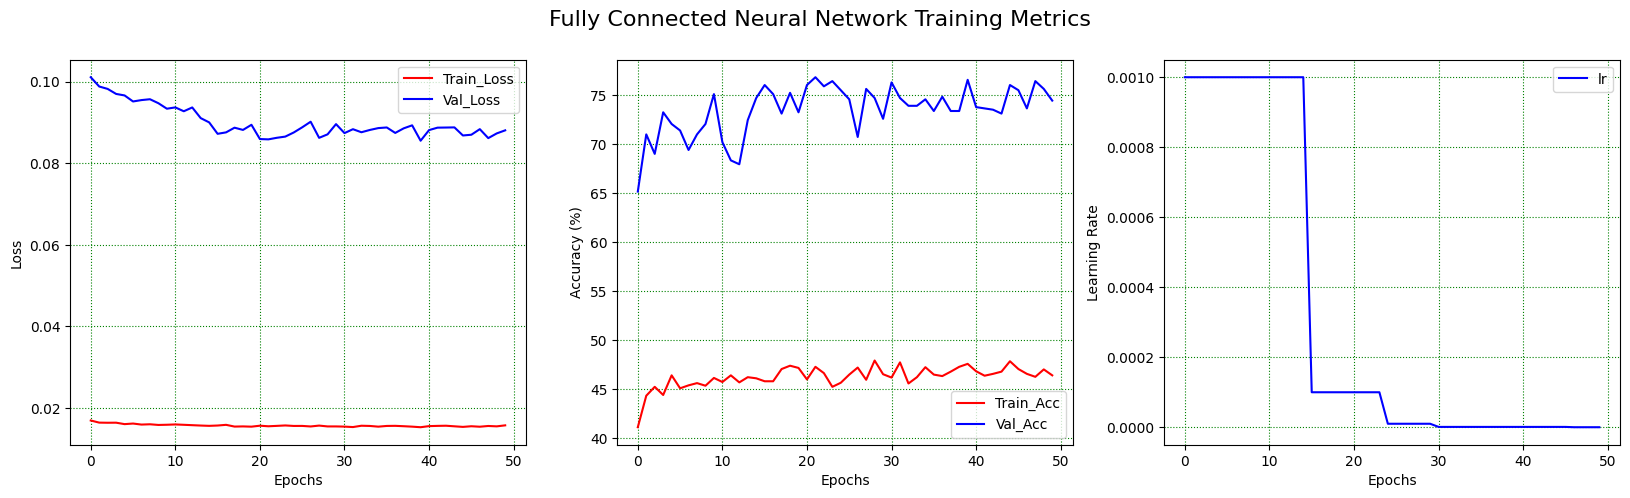

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

fc_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
fc_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
fc_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Fully Connected Neural Network Training Metrics', fontsize=16,)
plt.show()

# Custom CNN Layer - RESNet 9

In [17]:
def basic(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
  )

In [18]:
class RS_block(nn.Module):
  def __init__(self, in_channels, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, in_channels),
        basic(in_channels, in_channels),
    )

  def forward(self, x):
    return x + self.net(x)

In [19]:
class ResNet9(nn.Module):

  def __init__(self, in_channels=img_channels, num_classes=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, 64),
        basic(64, 128), nn.MaxPool2d(2),
        RS_block(128),
        basic(128, 256), nn.MaxPool2d(2),
        basic(256, 512), nn.MaxPool2d(2),
        RS_block(512),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    output = self.net(x)
    return output

In [20]:
model = ResNet9().cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [21]:
my_cnn = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="my_cnn")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.51it/s]


Training Loss = 0.3238879, Training Accuracy = 87.911
Testing Loss = 0.3027990, Testing Accuracy = 89.139
New best accuracy: 89.139 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.53it/s]


Training Loss = 0.1416009, Training Accuracy = 94.484
Testing Loss = 0.1383712, Testing Accuracy = 94.834
New best accuracy: 94.834 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.45it/s]


Training Loss = 0.1104339, Training Accuracy = 95.769
Testing Loss = 1.4715935, Testing Accuracy = 83.841
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.47it/s]


Training Loss = 0.1007200, Training Accuracy = 96.638
Testing Loss = 0.3734093, Testing Accuracy = 85.430
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.55it/s]


Training Loss = 0.0958629, Training Accuracy = 96.487
Testing Loss = 0.2394162, Testing Accuracy = 91.391
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.17it/s]


Training Loss = 0.0940810, Training Accuracy = 96.638
Testing Loss = 0.1004680, Testing Accuracy = 95.629
New best accuracy: 95.629 at epoch 6
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.49it/s]


Training Loss = 0.0684906, Training Accuracy = 97.582
Testing Loss = 0.2768295, Testing Accuracy = 89.404
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.45it/s]


Training Loss = 0.0503825, Training Accuracy = 98.224
Testing Loss = 0.1840743, Testing Accuracy = 93.113
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.63it/s]


Training Loss = 0.0596897, Training Accuracy = 97.884
Testing Loss = 2.4574079, Testing Accuracy = 53.642
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.34it/s]


Training Loss = 0.0782258, Training Accuracy = 97.355
Testing Loss = 0.2024819, Testing Accuracy = 94.834
**************************************************

Epoch 11


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.50it/s]


Training Loss = 0.0561174, Training Accuracy = 97.620
Testing Loss = 0.2846898, Testing Accuracy = 92.715
**************************************************

Epoch 12


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.49it/s]


Training Loss = 0.0387749, Training Accuracy = 98.149
Testing Loss = 0.1289733, Testing Accuracy = 94.702
**************************************************

Epoch 13


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.65it/s]


Training Loss = 0.0435045, Training Accuracy = 98.564
Testing Loss = 0.0282412, Testing Accuracy = 98.808
New best accuracy: 98.808 at epoch 13
**************************************************

Epoch 14


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.14it/s]


Training Loss = 0.0540124, Training Accuracy = 98.073
Testing Loss = 0.0544053, Testing Accuracy = 97.483
**************************************************

Epoch 15


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.36it/s]


Training Loss = 0.0358167, Training Accuracy = 98.942
Testing Loss = 0.0556589, Testing Accuracy = 97.881
**************************************************

Epoch 16


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.07it/s]


Training Loss = 0.0306503, Training Accuracy = 98.716
Testing Loss = 0.3795491, Testing Accuracy = 89.272
**************************************************

Epoch 17


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.30it/s]


Training Loss = 0.0182539, Training Accuracy = 99.320
Testing Loss = 0.0132077, Testing Accuracy = 99.470
New best accuracy: 99.470 at epoch 17
**************************************************

Epoch 18


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.28it/s]


Training Loss = 0.0171991, Training Accuracy = 99.358
Testing Loss = 0.0111029, Testing Accuracy = 99.735
New best accuracy: 99.735 at epoch 18
**************************************************

Epoch 19


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.50it/s]


Training Loss = 0.0164735, Training Accuracy = 99.358
Testing Loss = 0.0100376, Testing Accuracy = 99.868
New best accuracy: 99.868 at epoch 19
**************************************************

Epoch 20


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.53it/s]


Training Loss = 0.0178106, Training Accuracy = 99.244
Testing Loss = 0.0144781, Testing Accuracy = 99.470
**************************************************

Epoch 21


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.54it/s]


Training Loss = 0.0159523, Training Accuracy = 99.358
Testing Loss = 0.0124919, Testing Accuracy = 99.470
**************************************************

Epoch 22


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.57it/s]


Training Loss = 0.0135132, Training Accuracy = 99.471
Testing Loss = 0.0143906, Testing Accuracy = 99.470
**************************************************

Epoch 23


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.51it/s]


Training Loss = 0.0140113, Training Accuracy = 99.396
Testing Loss = 0.0108834, Testing Accuracy = 99.603
**************************************************

Epoch 24


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.52it/s]


Training Loss = 0.0146294, Training Accuracy = 99.320
Testing Loss = 0.0165877, Testing Accuracy = 99.338
**************************************************

Epoch 25


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.37it/s]


Training Loss = 0.0127088, Training Accuracy = 99.547
Testing Loss = 0.0195837, Testing Accuracy = 99.205
**************************************************

Epoch 26


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.41it/s]


Training Loss = 0.0132315, Training Accuracy = 99.509
Testing Loss = 0.0121376, Testing Accuracy = 99.735
**************************************************

Epoch 27


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.15it/s]


Training Loss = 0.0161866, Training Accuracy = 99.433
Testing Loss = 0.0145739, Testing Accuracy = 99.470
**************************************************

Epoch 28


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.35it/s]


Training Loss = 0.0108311, Training Accuracy = 99.736
Testing Loss = 0.0135107, Testing Accuracy = 99.205
**************************************************

Epoch 29


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.35it/s]


Training Loss = 0.0128886, Training Accuracy = 99.622
Testing Loss = 0.0195633, Testing Accuracy = 99.205
**************************************************

Epoch 30


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.41it/s]


Training Loss = 0.0122249, Training Accuracy = 99.660
Testing Loss = 0.0111861, Testing Accuracy = 99.735
**************************************************

Epoch 31


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.56it/s]


Training Loss = 0.0099364, Training Accuracy = 99.698
Testing Loss = 0.0087474, Testing Accuracy = 99.735
**************************************************

Epoch 32


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.51it/s]


Training Loss = 0.0124740, Training Accuracy = 99.584
Testing Loss = 0.0094632, Testing Accuracy = 99.735
**************************************************

Epoch 33


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.52it/s]


Training Loss = 0.0112082, Training Accuracy = 99.660
Testing Loss = 0.0116778, Testing Accuracy = 99.603
**************************************************

Epoch 34


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.43it/s]


Training Loss = 0.0129541, Training Accuracy = 99.471
Testing Loss = 0.0075663, Testing Accuracy = 99.735
**************************************************

Epoch 35


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.33it/s]


Training Loss = 0.0098816, Training Accuracy = 99.622
Testing Loss = 0.0090650, Testing Accuracy = 99.735
**************************************************

Epoch 36


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.48it/s]


Training Loss = 0.0104874, Training Accuracy = 99.736
Testing Loss = 0.0087839, Testing Accuracy = 99.735
**************************************************

Epoch 37


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.46it/s]


Training Loss = 0.0081361, Training Accuracy = 99.736
Testing Loss = 0.0080808, Testing Accuracy = 99.735
**************************************************

Epoch 38


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.41it/s]


Training Loss = 0.0093939, Training Accuracy = 99.622
Testing Loss = 0.0086600, Testing Accuracy = 99.735
**************************************************

Epoch 39


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.43it/s]


Training Loss = 0.0085994, Training Accuracy = 99.660
Testing Loss = 0.0086767, Testing Accuracy = 99.735
**************************************************

Epoch 40


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.54it/s]


Training Loss = 0.0106080, Training Accuracy = 99.622
Testing Loss = 0.0085685, Testing Accuracy = 99.735
**************************************************

Epoch 41


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.33it/s]


Training Loss = 0.0081297, Training Accuracy = 99.698
Testing Loss = 0.0097947, Testing Accuracy = 99.603
**************************************************

Epoch 42


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.43it/s]


Training Loss = 0.0096965, Training Accuracy = 99.660
Testing Loss = 0.0079577, Testing Accuracy = 99.735
**************************************************

Epoch 43


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.25it/s]


Training Loss = 0.0098596, Training Accuracy = 99.736
Testing Loss = 0.0099024, Testing Accuracy = 99.603
**************************************************

Epoch 44


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.41it/s]


Training Loss = 0.0084388, Training Accuracy = 99.773
Testing Loss = 0.0086800, Testing Accuracy = 99.735
**************************************************

Epoch 45


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.27it/s]


Training Loss = 0.0090298, Training Accuracy = 99.736
Testing Loss = 0.0081965, Testing Accuracy = 99.735
**************************************************

Epoch 46


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.32it/s]


Training Loss = 0.0106254, Training Accuracy = 99.660
Testing Loss = 0.0081634, Testing Accuracy = 99.735
**************************************************

Epoch 47


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.23it/s]


Training Loss = 0.0077356, Training Accuracy = 99.773
Testing Loss = 0.0082189, Testing Accuracy = 99.735
**************************************************

Epoch 48


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.45it/s]


Training Loss = 0.0069513, Training Accuracy = 99.849
Testing Loss = 0.0080472, Testing Accuracy = 99.735
**************************************************

Epoch 49


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.36it/s]


Training Loss = 0.0076841, Training Accuracy = 99.811
Testing Loss = 0.0089351, Testing Accuracy = 99.735
**************************************************

Epoch 50


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.47it/s]

Training Loss = 0.0077249, Training Accuracy = 99.811
Testing Loss = 0.0082938, Testing Accuracy = 99.735
**************************************************



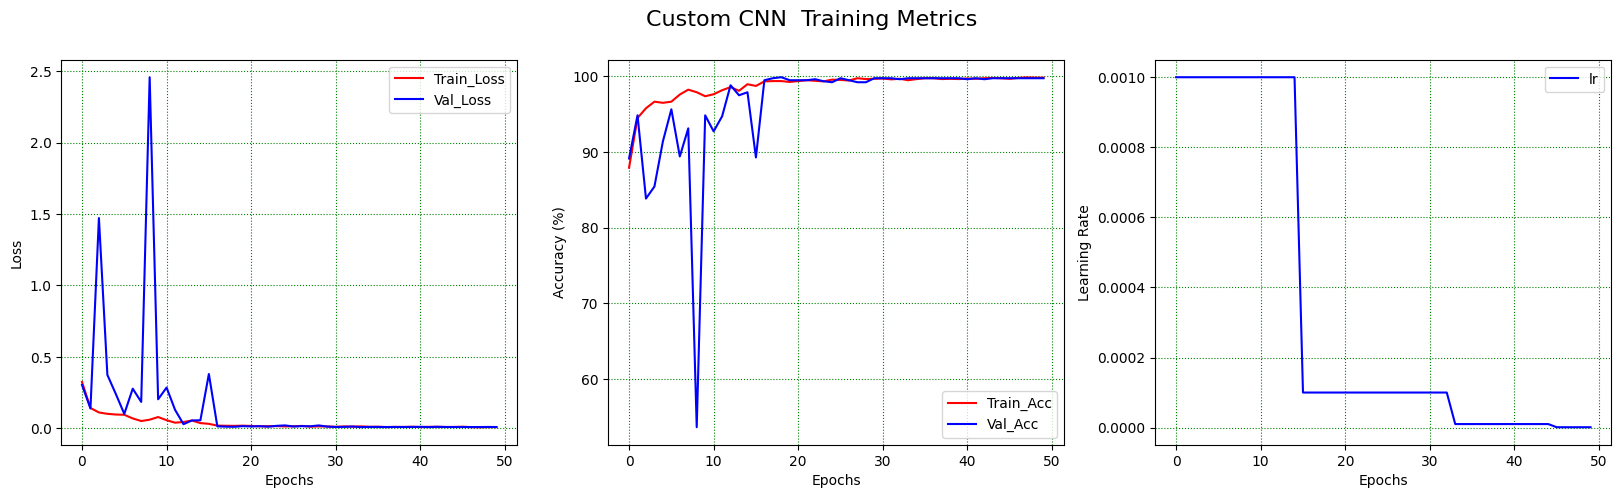

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

my_cnn.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
my_cnn.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
my_cnn.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Transfer Learning

In [23]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 225MB/s]


In [24]:
model.eval()

for params in model.parameters():
  params.requires_grad = False

In [25]:
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

In [26]:
model = model.cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [27]:
transfer_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=10, experiment_name="tranfer")

Epoch 1


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.36it/s]


Training Loss = 0.6446546, Training Accuracy = 75.633
Testing Loss = 0.2687984, Testing Accuracy = 93.775
New best accuracy: 93.775 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.72it/s]


Training Loss = 0.1798296, Training Accuracy = 96.147
Testing Loss = 0.1536995, Testing Accuracy = 96.026
New best accuracy: 96.026 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.61it/s]


Training Loss = 0.1114396, Training Accuracy = 97.355
Testing Loss = 0.1004749, Testing Accuracy = 97.483
New best accuracy: 97.483 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.72it/s]


Training Loss = 0.0905432, Training Accuracy = 97.620
Testing Loss = 0.0744979, Testing Accuracy = 98.411
New best accuracy: 98.411 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.72it/s]


Training Loss = 0.0816676, Training Accuracy = 97.582
Testing Loss = 0.0538462, Testing Accuracy = 99.073
New best accuracy: 99.073 at epoch 5
**************************************************

Epoch 6


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.34it/s]


Training Loss = 0.0675994, Training Accuracy = 98.262
Testing Loss = 0.0402455, Testing Accuracy = 99.470
New best accuracy: 99.470 at epoch 6
**************************************************

Epoch 7


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.30it/s]


Training Loss = 0.0584839, Training Accuracy = 98.111
Testing Loss = 0.0399064, Testing Accuracy = 99.338
**************************************************

Epoch 8


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.71it/s]


Training Loss = 0.0555988, Training Accuracy = 98.300
Testing Loss = 0.0364370, Testing Accuracy = 99.338
**************************************************

Epoch 9


Evaluating: 100%|██████████| 76/76 [00:09<00:00,  7.74it/s]


Training Loss = 0.0512197, Training Accuracy = 98.451
Testing Loss = 0.0302233, Testing Accuracy = 99.603
New best accuracy: 99.603 at epoch 9
**************************************************

Epoch 10


Evaluating: 100%|██████████| 76/76 [00:10<00:00,  7.60it/s]

Training Loss = 0.0466510, Training Accuracy = 98.716
Testing Loss = 0.0316997, Testing Accuracy = 99.470
**************************************************



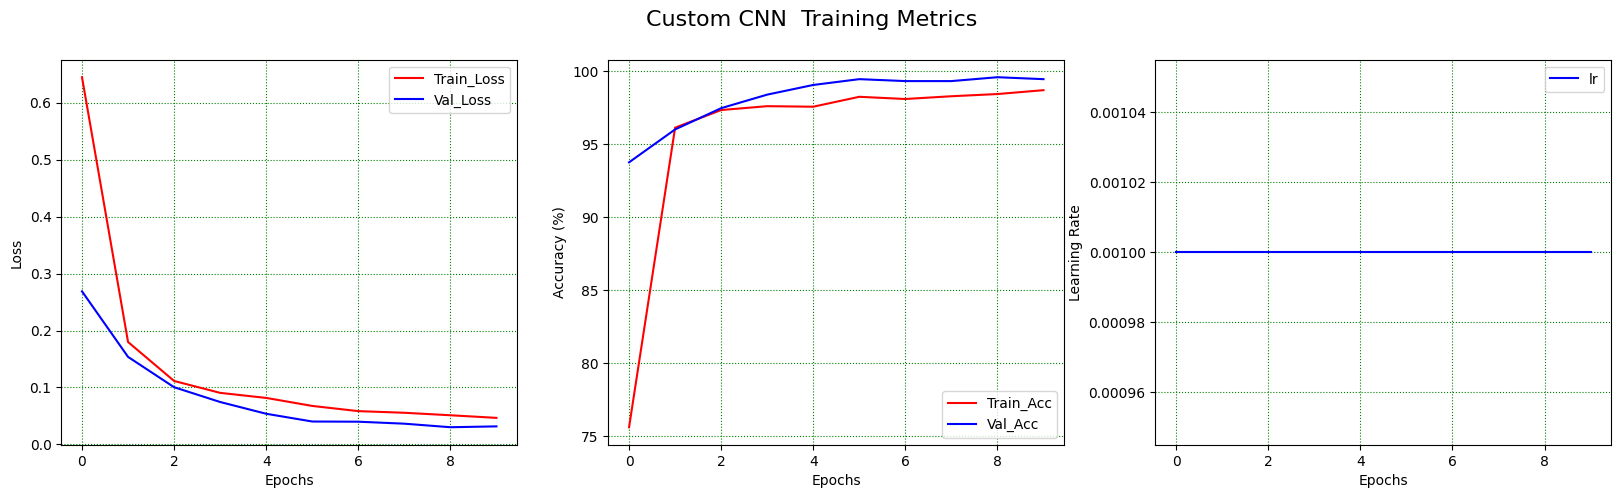

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

transfer_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
transfer_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
transfer_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()